In [ ]:
!pip install gdown

     |████████████████████████████████| 77 kB 3.9 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-0b049624-20c4-4f4d-a50d-bc30b98300c0/bin/python -m pip install --upgrade pip' command.


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1ZJDrnVXUT47skwwhTrjcq8rAfDoJ-389/view?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=1ZJDrnVXUT47skwwhTrjcq8rAfDoJ-389
To: /databricks/driver/ml-1m.zip
100%|██████████████████████████████████████| 6.01M/6.01M [00:00<00:00, 62.4MB/s]


In [ ]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: __MACOSX/._ml-1m        
  inflating: ml-1m/movies.dat        
  inflating: __MACOSX/ml-1m/._movies.dat  
  inflating: ml-1m/ratings.dat       
  inflating: __MACOSX/ml-1m/._ratings.dat  
  inflating: ml-1m/README            
  inflating: __MACOSX/ml-1m/._README  
  inflating: ml-1m/users.dat         
  inflating: __MACOSX/ml-1m/._users.dat  


In [ ]:
!ls ml-1m

README	movies.dat  ratings.dat  users.dat


1it [04:07, 247.56s/it]

Rank: 5, Reg: 0.01, MSE: 0.7534, RMSE: 0.8680


2it [07:38, 225.91s/it]

Rank: 5, Reg: 0.05, MSE: 0.7518, RMSE: 0.8670


3it [10:59, 214.75s/it]

Rank: 5, Reg: 0.1, MSE: 0.7663, RMSE: 0.8754


4it [14:39, 216.54s/it]

Rank: 10, Reg: 0.01, MSE: 0.7626, RMSE: 0.8732


5it [18:20, 218.48s/it]

Rank: 10, Reg: 0.05, MSE: 0.7319, RMSE: 0.8555


6it [22:04, 220.23s/it]

Rank: 10, Reg: 0.1, MSE: 0.7487, RMSE: 0.8653


7it [26:04, 226.76s/it]

Rank: 15, Reg: 0.01, MSE: 0.7860, RMSE: 0.8866


8it [30:03, 230.67s/it]

Rank: 15, Reg: 0.05, MSE: 0.7312, RMSE: 0.8551


9it [34:08, 227.60s/it]

Rank: 15, Reg: 0.1, MSE: 0.7438, RMSE: 0.8624


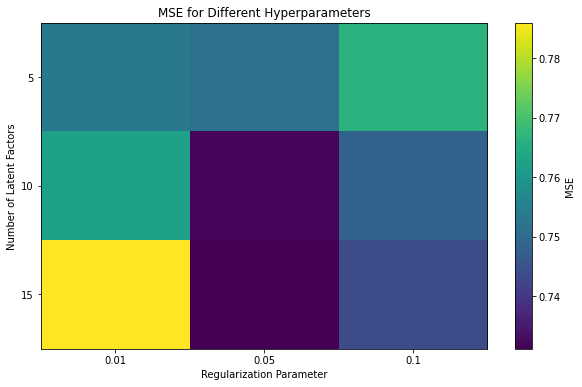

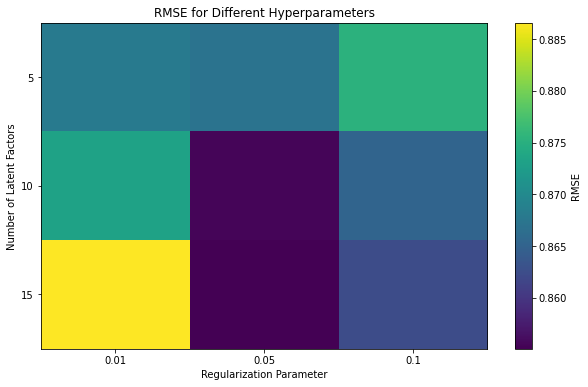

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import os

# Define the hyperparameter search space
latent_factors = [5, 10, 15]
regularization_params = [0.01, 0.05, 0.1]

# Initialize lists to store the results
mse_results = []
rmse_results = []

# Define the schema for the ratings dataset
schema = StructType([
    StructField("UserID", IntegerType(), True),
    StructField("MovieID", IntegerType(), True),
    StructField("Rating", IntegerType(), True),
    StructField("Timestamp", StringType(), True)
])
current_dir = os.path.abspath(os.getcwd())
# Read the ratings dataset using the schema
ratings = spark.read.csv(os.path.join("file:/databricks/driver/ml-1m/ratings.dat"), schema=schema, sep="::")

# Split the dataset into training and testing sets
train, test = ratings.randomSplit([0.8, 0.2], seed=42)

# Define the regression evaluator for MSE and RMSE
mse_evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="Rating",
    predictionCol="prediction"
)
rmse_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Rating",
    predictionCol="prediction"
)

# Perform the grid search
for rank, reg in tqdm(itertools.product(latent_factors, regularization_params)):
    # Define the ALS model with the current hyperparameters
    als = ALS(
        userCol="UserID",
        itemCol="MovieID",
        ratingCol="Rating",
        nonnegative=True,
        implicitPrefs=False,
        coldStartStrategy="drop",
        rank=rank,
        maxIter=15,
        regParam=reg
    )

    # Fit the ALS model
    model = als.fit(train)

    # Generate predictions on the test set
    predictions = model.transform(test)

    # Calculate and store MSE and RMSE
    mse = mse_evaluator.evaluate(predictions)
    rmse = rmse_evaluator.evaluate(predictions)
    mse_results.append(mse)
    rmse_results.append(rmse)
    print(f"Rank: {rank}, Reg: {reg}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Reshape the results for visualization
mse_results = np.array(mse_results).reshape(len(latent_factors), len(regularization_params))
rmse_results = np.array(rmse_results).reshape(len(latent_factors), len(regularization_params))

# Plot the MSE heatmap
plt.figure(figsize=(10, 6))
plt.imshow(mse_results, cmap='viridis', aspect='auto')
plt.colorbar(label='MSE')
plt.xticks(range(len(regularization_params)), regularization_params)
plt.yticks(range(len(latent_factors)), latent_factors)
plt.xlabel('Regularization Parameter')
plt.ylabel('Number of Latent Factors')
plt.title('MSE for Different Hyperparameters')
plt.show()

# Plot the RMSE heatmap
plt.figure(figsize=(10, 6))
plt.imshow(rmse_results, cmap='viridis', aspect='auto')
plt.colorbar(label='RMSE')
plt.xticks(range(len(regularization_params)), regularization_params)
plt.yticks(range(len(latent_factors)), latent_factors)
plt.xlabel('Regularization Parameter')
plt.ylabel('Number of Latent Factors')
plt.title('RMSE for Different Hyperparameters')
plt.show()